In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from analyze import * # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm
import shutil

%matplotlib inline

In [2]:
thresholds = get_thresholds(find_regular_run(18190))

In [3]:
acc, stat, sys = acceptance_3runs(18190, 18191, 18192, thresholds)

/home/awalsh272/SPE/SPE/analyze.py:85: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)


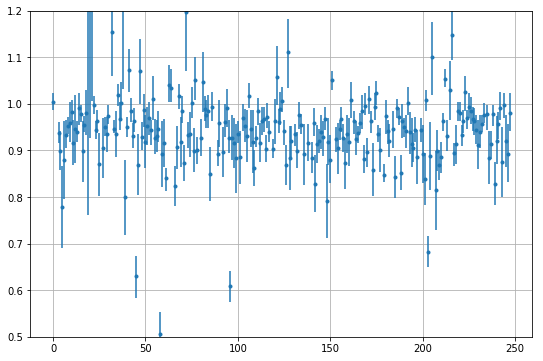

In [4]:
plt.figure(figsize=(9,6))
plt.errorbar(np.arange(248), acc, yerr=np.array([np.sqrt(stat[0]**2+sys**2), np.sqrt(stat[1]**2+sys**2)]) , linestyle='None', marker='.')
plt.grid()
plt.ylim(0.5, 1.2)
plt.show()

In [5]:
data_dir_base = '/project/lgrandi/xenon1t/spe_acceptance/data'

def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

runlists = []
for runlist in os.listdir('runlists'):
    if all_data_exists(file_to_list(runlist)):
        runlists.append(runlist)

In [6]:
bottom_runs = []
acceptance = []
errs = []

for runlist in tqdm(runlists):
    l = file_to_list(runlist)
    
    if l[0] < 6846:
        continue
        #thresholds = np.load('selftrigger_thresholds_SR1_before6846.npz')['thresholds']
    
    elif 6846 < l[0] < 18000:
        thresholds = np.load('selftrigger_thresholds_SR1_after6846.npz')['thresholds']
    elif 18000 < l[0]:
        thresholds = get_thresholds(find_regular_run(l[0]))
        
    acc, stat, sys = acceptance_3runs(l[0], l[1], l[2], thresholds)
    
    bottom_runs.append(l[0])
    acceptance.append(acc)
    errs.append(stat)

    
acceptance = np.array(acceptance)
bottom_runs = np.array(bottom_runs)
errs = np.array(errs)

  0%|          | 0/107 [00:00<?, ?it/s]/home/awalsh272/SPE/SPE/analyze.py:85: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)
 36%|███▌      | 38/107 [04:48<07:30,  6.54s/it]/home/awalsh272/SPE/SPE/analyze.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/awalsh272/SPE/SPE/analyze.py:112: RuntimeWarning: invalid value encountered in true_divide
  return 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/project/lgrandi/anaconda3/envs/pax_v6.8.0/lib/python3.4/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 107/107 [11:49<00:00,  6.93s/it]


In [7]:
acceptance[:,0]

array([  9.60160547e-01,   9.41863122e-01,   9.17277298e-01,
         9.58624443e-01,   9.75682397e-01,   1.07554426e+00,
         9.33009889e-01,   9.45787599e-01,   9.72023678e-01,
         9.41598846e-01,   9.32215792e-01,  -2.82754865e-04,
         9.27473012e-01,   9.41169989e-01,   9.45079636e-01,
         9.24611323e-01,   9.19075972e-01,   9.84349544e-01,
         9.33787282e-01,   9.26873261e-01,   9.32047953e-01,
         9.23151984e-01,   9.19577894e-01,   9.23151809e-01,
         9.34863145e-01,   9.61143713e-01,   9.12176363e-01,
         9.19059441e-01,   9.56706208e-01,   9.39552629e-01,
         9.37338374e-01,   9.57881767e-01,   9.41551416e-01,
         9.52544515e-01,   9.33878631e-01,   9.02674293e-01,
         9.45193537e-01,   8.30534194e-01,   9.39795811e-01,
         9.40293960e-01,   9.16533674e-01,   9.34198773e-01,
         1.72445487e-02,   9.21772701e-01,   9.20784171e-01,
         9.45061734e-01,   9.38373048e-01,   9.42000437e-01,
         9.49953596e-01,

In [8]:
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import datetime

months = mdates.MonthLocator()
years = mdates.YearLocator()
datetimefmt = mdates.DateFormatter("%d-%m")


dates = [get_run_time(run) for run in bottom_runs]
today = datetime.date.today()


def plot_channel(ch):
    f, ax = plt.subplots(figsize=(8,5))
    ax.fmt_xdata = mdates.DateFormatter('%d-%m')
    ax.errorbar(dates, acceptance[:, ch], yerr=[errs[:,0,ch], errs[:,1,ch]], linestyle='None', 
                color='navy', marker='.')
    ax.xaxis.set_major_formatter(datetimefmt)
    ax.xaxis.set_major_locator(months)
    plt.xlabel('Date')
    plt.ylabel('SPE Acceptance')
    plt.title('Channel %d' %ch)
    f.autofmt_xdate()
    plt.grid()
    plt.ylim(-0.1, 1.1)
    plt.xlim(datetime.date(year=2018, month=1, day=1), datetime.date(year=2018, month=5, day=1) )
    #plt.savefig('plots/ch%d.png' % ch)
    plt.show()

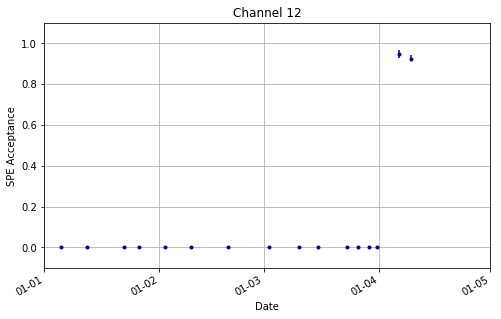

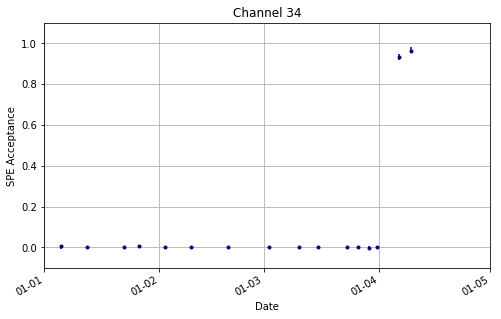

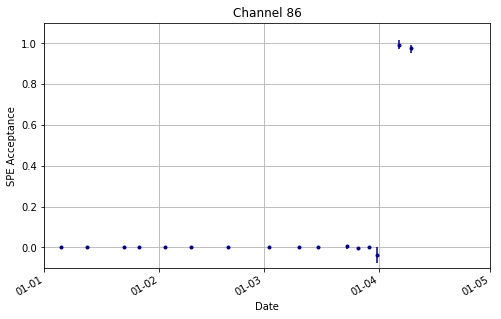

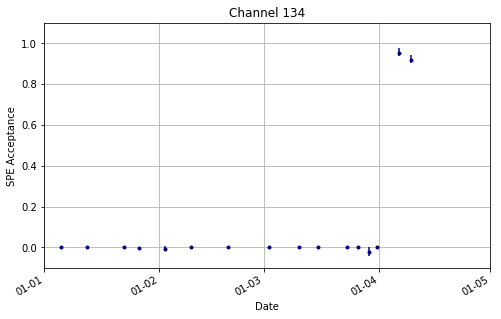

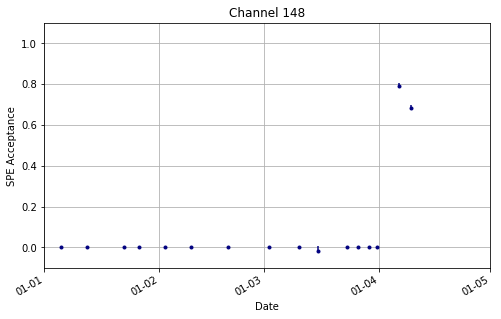

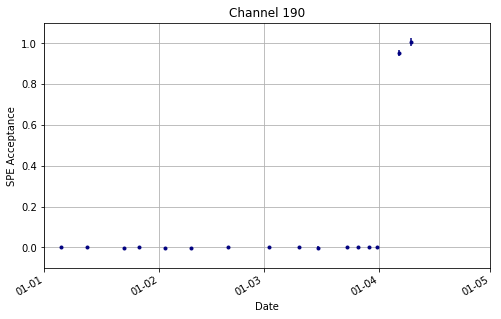

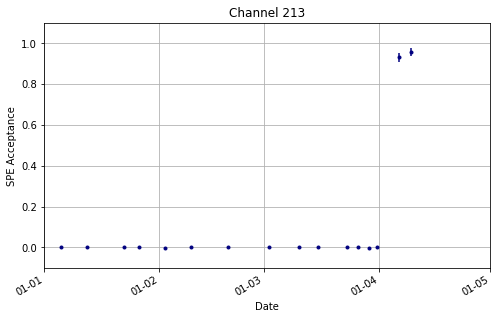

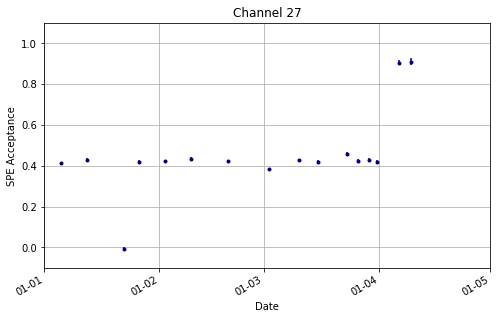

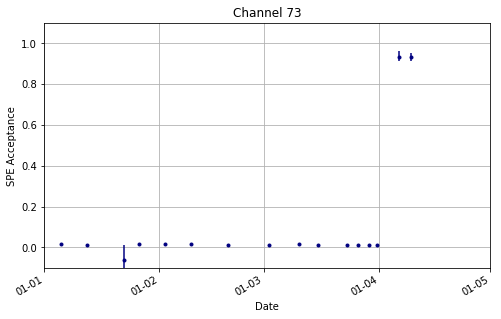

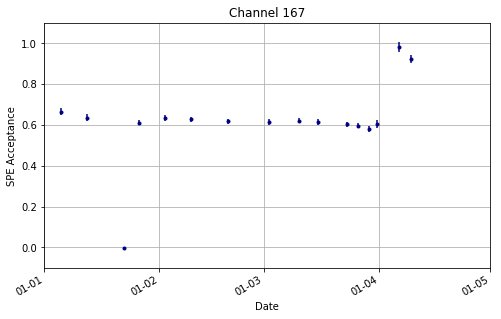

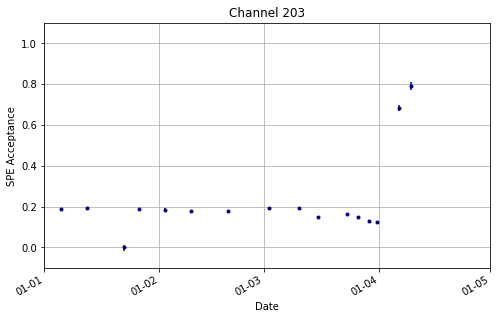

In [9]:
table = "^Channel^Acceptance^\n"

for ch in [12, 34, 86, 134, 148, 190, 213]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(acceptance[indices, ch])
    table += "|%d|%0.2f|\n" % (ch, a)

table2 = "^Channel^Acceptance^Uncertainty^\n"
for ch in [27, 73, 167, 203]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(acceptance[indices, ch])
    table2 += "|%d|%0.2f|\n" % (ch, a)

In [10]:
print(table)

print(table2)

^Channel^Acceptance^
|12|0.93|
|34|0.95|
|86|0.98|
|134|0.94|
|148|0.74|
|190|0.98|
|213|0.94|

^Channel^Acceptance^Uncertainty^
|27|0.91|
|73|0.93|
|167|0.95|
|203|0.74|

